# Алгоритмы интеллектуальной обработки больших объемов данных
## Семинар, учимся настраивать параметры бустинга


Разберем, например, xgboost:
https://xgboost.readthedocs.io/en/latest/parameter.html

https://xgboost.readthedocs.io/en/latest/python/python_api.html

Параметры можно разделить на группы. 



1) Общие параметры алгоритма, например, тип бустинга

2) Параметры обучения бустинга, например число итераций, learning rate

3) Параметры построения деревьев, например, глубина, минимальное число элементов в листе

4) Параметры стохастики, subsample, colsample

5) Регуляриазция, например, lambda


ПРАВИЛЬНОГО алгоритма для тюнинга нет, вот один из вариантов, которые часто используют на практике.

1) Возьмите дефолтное параметры. Поставьте нужные loss и eval функции.  Измените максимальное  число деревьев, чтобы было не долго делать эксперименты

2) Подберите для него alpha, чтобы алгоритм не переобучался

3) Подберите параметры сложности дерева, например,  глубину, мин число объектов в листах, мин значение для расщепления и тд

4) Подберите паарметры стохастики

5) Подберите регуляризацию

6) Уменьшите leraning rate и обучите максимальное число деревьев, чтобы не переобучалось

Давайте настроим параметры бустинга на нашем конкурсе!

In [102]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [103]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [170]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:25]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 25) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [97]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedKFold, KFold
import matplotlib.pyplot as plt
# clf = lgb.LGBMClassifier()

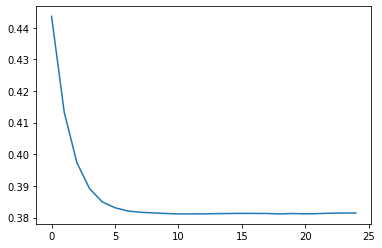

In [107]:
param_dist = {'n_estimators': 25, 'verbosity': 1, 'objective': 'reg:squarederror'}
splits = 5
rkf = RepeatedKFold(n_splits=splits, n_repeats=1, random_state=100500)
res = []
for train_idx, test_idx in rkf.split(X_train, y_train):
    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_ts, y_ts = X_train[test_idx], y_train[test_idx]
    
    clf = xgb.XGBClassifier(**param_dist)

    clf.fit(X_tr, y_tr,
        eval_set=[(X_ts, y_ts)],
        #eval_metric='rmse',
        verbose=False)

    evals_result = clf.evals_result()
    
    if len(res) > 0:
        res = [res[i] + e_res for i, e_res in enumerate(evals_result['validation_0']['rmse'])]
    else:
        res = evals_result['validation_0']['rmse']

plt.plot([r / splits for r in res])

In [108]:
param_dist['n_estimators'] = 20

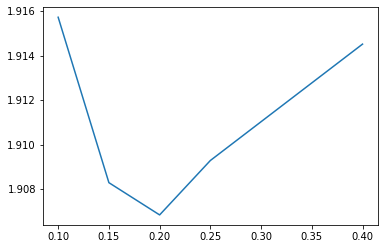

In [109]:
etas = [0.1, 0.15, 0.2, 0.25, 0.4]
splits=5
result = [0] * len(etas)
kf = KFold(n_splits=splits, shuffle=True, random_state=100500)
for train_idx, test_idx in kf.split(X_train, y_train):
    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_ts, y_ts = X_train[test_idx], y_train[test_idx]
    tmp = []
    for eta in etas:
        clf = xgb.XGBClassifier(learning_rate=eta, **param_dist)
        clf.fit(X_tr, y_tr,
            eval_set=[(X_ts, y_ts)],
            eval_metric='rmse',
            verbose=False)
        evals_result = clf.evals_result()
        tmp.append(evals_result['validation_0']['rmse'][-1])
    result = [r + tmp[i] for i, r in enumerate(result)]

plt.plot(etas, result)

In [110]:
param_dist['learning_rate'] = 0.2

In [111]:
depths = range(1, 8, 2)
leaves = range(1, 10, 2)
steps = [0, 0.1, 0.2, 0.5, 1, 2]
splits=5
result = {}
kf = KFold(n_splits=splits, shuffle=True, random_state=100500)
for train_idx, test_idx in kf.split(X_train, y_train):
    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_ts, y_ts = X_train[test_idx], y_train[test_idx]
    tmp = {}
    for depth in depths:
        for leaf in leaves:
            for step in steps:
                clf = xgb.XGBClassifier(max_depth=depth, min_child_weight=leaf, 
                                        max_delta_step=step, **param_dist)
                clf.fit(X_tr, y_tr,
                        eval_set=[(X_ts, y_ts)],
                        eval_metric='rmse',
                        verbose=False)
                evals_result = clf.evals_result()
                idx = '({}, {}, {})'.format(depth, leaf, step)
                tmp[idx] = evals_result['validation_0']['rmse'][-1]
    
    if len(result) > 0:
        for key in result.keys():
            result[key] += tmp[key]
    else:
        result = tmp

In [112]:
key_min = min(result.keys(), key=(lambda k: result[k]))
print(key_min, result[key_min])

(5, 1, 0.5) 1.905189


In [115]:
keys = key_min.split(', ')
param_dist['max_depth'] = int(keys[0][1:])
param_dist['min_child_weight'] = float(keys[1])
param_dist['max_delta_step'] = float(keys[2][:-1])

In [119]:
bytrees = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
bylevels = [0.5, 0.8, 1]
bynodes = [0.5, 0.8, 1]
subsamples = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
splits = 5
result = {}
kf = KFold(n_splits=splits, shuffle=True, random_state=100500)
for train_idx, test_idx in kf.split(X_train, y_train):
    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_ts, y_ts = X_train[test_idx], y_train[test_idx]
    tmp = {}
    for smp in subsamples:
        #for bt in bytrees:
        #    for bl in bylevels:
        #        for bn in bynodes:
                    clf = xgb.XGBClassifier(#colsample_bytree=bt,# colsample_bylevel=bl, colsample_bynode=bn, 
                                            subsample=smp, **param_dist)
                    clf.fit(X_tr, y_tr,
                            eval_set=[(X_ts, y_ts)],
                            eval_metric='rmse',
                            verbose=False)
                    evals_result = clf.evals_result()
                    idx = '({})'.format(smp)#, bt, bl, bn)
                    tmp[idx] = evals_result['validation_0']['rmse'][-1]

    if len(result) > 0:
        for key in result.keys():
            result[key] += tmp[key]
    else:
        result = tmp

In [120]:
key_min = min(result.keys(), key=(lambda k: result[k]))
print(key_min, result[key_min])

(0.8) 1.904487


In [122]:
keys = key_min.split(', ')
param_dist['subsample'] = float(keys[0][1:-1])
#param_dist['colsample_bytree'] = float(keys[1][:-1])
#param_dist['colsample_bylevel'] = float(keys[2])
#param_dist['colsample_bynode'] = float(keys[3][:-1])

In [123]:
lambdas = [0.5, 1, 3, 7, 10, 20, 40]
splits = 5
result = []
kf = KFold(n_splits=splits, shuffle=True, random_state=100500)
for train_idx, test_idx in kf.split(X_train, y_train):
    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_ts, y_ts = X_train[test_idx], y_train[test_idx]
    tmp = []
    for lam in lambdas:
        clf = xgb.XGBClassifier(reg_lambda=lam, **param_dist)
        clf.fit(X_tr, y_tr,
                eval_set=[(X_ts, y_ts)],
                eval_metric='rmse',
                verbose=False)
        evals_result = clf.evals_result()
        tmp.append(evals_result['validation_0']['rmse'][-1])

    if len(result) > 0:
        for k, _ in enumerate(result):
            result[k] += tmp[k]
    else:
        result = tmp

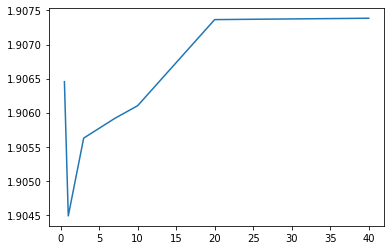

In [124]:
plt.plot(lambdas, result)

In [125]:
param_dist['lambda'] = 1

In [153]:
spws = [0.5 + 0.3 * r for r in range(11)]
splits = 5
result = []
kf = KFold(n_splits=splits, shuffle=True, random_state=100500)
for train_idx, test_idx in kf.split(X_train, y_train):
    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_ts, y_ts = X_train[test_idx], y_train[test_idx]
    tmp = []
    for spw in spws:
        clf = xgb.XGBClassifier(scale_pos_weight=spw, **param_dist)
        clf.fit(X_tr, y_tr,
                eval_set=[(X_ts, y_ts)],
                eval_metric='rmse',
                verbose=False)
        evals_result = clf.evals_result()
        tmp.append(evals_result['validation_0']['rmse'][-1])

    if len(result) > 0:
        for k, _ in enumerate(result):
            result[k] += tmp[k]
    else:
        result = tmp

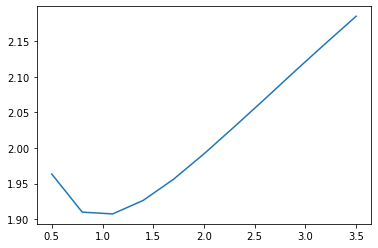

In [154]:
plt.plot(spws, result)

Задача: обучите на этих фичах (число фичей рассатриваем как гипераматр) бустинг, подберите параметры, засабмитьте на кагл. Побейте 0.62 паблик скор за сутки.  Удачи!

In [156]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))
test_data.head()

,pair_id,group_id,doc_id
0,11691,130,6710
1,11692,130,4030
2,11693,130,5561
3,11694,130,4055
4,11695,130,4247


In [158]:
X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:25]    )
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print(X_test.shape, groups_test.shape)

(16627, 25) (16627,)


In [159]:
param_dist['learning_rate'] = 0.1

In [160]:
from sklearn.model_selection import train_test_split
X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.2)

In [162]:
%%time

#del param_dist['n_estimators']
param_dist['max_depth'] = 3
old = -1
losses = []
for n_est in range(10, 200, 5):
    test_clf = xgb.XGBClassifier(n_estimators=n_est, **param_dist)
    test_clf.fit(X_tr, y_tr,
                eval_set=[(X_ts, y_ts)],
                eval_metric='rmse',
                verbose=False)
    evals_result = test_clf.evals_result()
    #if old < 0 or old > evals_result['validation_0']['rmse'][-1]:
    old = evals_result['validation_0']['rmse'][-1]
    losses.append(old)
    
#print(param_dist['n_estimators'])

CPU times: user 35.9 s, sys: 112 ms, total: 36 s
Wall time: 37 s


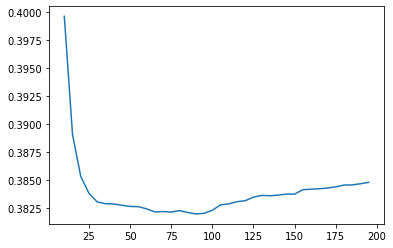

In [163]:
plt.plot(range(10, 200, 5), losses)

In [164]:
%%time

#del param_dist['n_estimators']
param_dist['max_depth'] = 3
old = -1
losses = []
for n_est in range(10, 200, 5):
    test_clf = xgb.XGBClassifier(n_estimators=n_est, **param_dist)
    test_clf.fit(X_tr, y_tr,
                eval_set=[(X_ts, y_ts)],
                eval_metric='rmse',
                verbose=False)
    evals_result = test_clf.evals_result()
    #if old < 0 or old > evals_result['validation_0']['rmse'][-1]:
    old = evals_result['validation_0']['rmse'][-1]
    losses.append(old)
    
#print(param_dist['n_estimators'])

CPU times: user 26 s, sys: 206 ms, total: 26.2 s
Wall time: 27.8 s


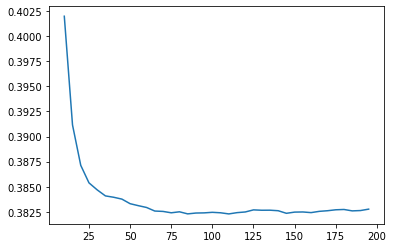

In [165]:
plt.plot(range(10, 200, 5), losses)

In [166]:
%%time

#del param_dist['n_estimators']
param_dist['max_depth'] = 3
param_dist['scale_pos_weight'] = 2.3
old = -1
losses = []
for n_est in range(10, 200, 5):
    test_clf = xgb.XGBClassifier(n_estimators=n_est, **param_dist)
    test_clf.fit(X_tr, y_tr,
                eval_set=[(X_ts, y_ts)],
                eval_metric='rmse',
                verbose=False)
    evals_result = test_clf.evals_result()
    #if old < 0 or old > evals_result['validation_0']['rmse'][-1]:
    old = evals_result['validation_0']['rmse'][-1]
    losses.append(old)
    
#print(param_dist['n_estimators'])

CPU times: user 23.5 s, sys: 91.7 ms, total: 23.6 s
Wall time: 23.8 s


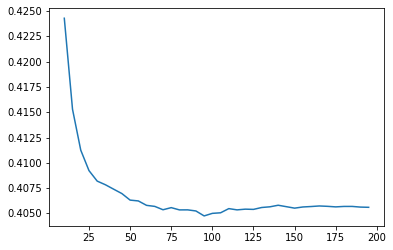

In [167]:
plt.plot(range(10, 200, 5), losses)

In [171]:
param_dist['n_estimators'] = 150
param_dist['scale_pos_weight'] = 2.3
param_dist['learning_rate'] = 0.01
param_dist['subsample'] = 0.8
param_dist['max_depth'] = 3
print(param_dist)
test_clf = xgb.XGBClassifier(**param_dist)
test_clf.fit(X_train, y_train)
y_test_pred = test_clf.predict(X_test)

{'verbosity': 1, 'objective': 'reg:squarederror', 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1.0, 'max_delta_step': 0.5, 'subsample': 0.8, 'lambda': 1, 'scale_pos_weight': 2.3, 'n_estimators': 150}


In [172]:
data = {'pair_id': np.asarray(test_data.pair_id), 'target': y_test_pred}
df = pd.DataFrame(data=data)
df = df.set_index(keys=['pair_id'])
df.to_csv('submitBoost.csv')
df.head()

,target
pair_id,
11691,0
11692,1
11693,1
11694,1
11695,1


In [173]:
print((y_test_pred == 1).astype(int).sum())
print((y_test_pred == 0).astype(int).sum())

print((y_train == 1).astype(int).sum())
print((y_train == 0).astype(int).sum())

5978
10649
3361
8329
